In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

## Problem Description

This project uses deep learning to classify tweets based on if they are about real disasters. This is a Kaggle competition at https://www.kaggle.com/competitions/nlp-getting-started. The focus is on testing out recurrent neural networks (RNNs) to perform this classification.

We will utilize natural language processing (NLP), a field of computer science that focuses on how computing technology can work with "natural language," language that occurs naturally with humans. In this scenario, we are looking at a subset of tweets that are written in English and are illustrative of how people communicate in a natural manner with the English language. The "natural" aspect speaks to how people actually use the language rather than just focusing on the formal ways in which people are supposed to use the language. The RNNs we will test out require numbers as inputs, so our use of NLP will include converting written text into numeric representation as well as capturing relationships and context within the language. 

We will need the context abilities of RNNs since the use of disaster-related words on their own may not indicate an actual disaster. For example, someone may tweet "This is a disaster," using the literal word "disaster" but referring metaphorically to a situation that is not a disaster that, for instance, a disaster relief group needs to respond to.

After building the models, the competition asks us to submit files with target labels for the test set to evaluate and compare with other submissions based on F1 score.

## Data Description & Initial Preprocessing

In [2]:
in_dir = '/kaggle/input/disaster-tweet-raw-data'
out_dir = '/kaggle/working'

df_train = pd.read_csv(f'{in_dir}/train.csv')
df_test = pd.read_csv(f'{in_dir}/test.csv')
# df_sample_submission = pd.read_csv('./data/sample_submission.csv')
# df_sample_submission.head()

In [3]:
print(f'The training set has {df_train.shape[0]:,} rows and {df_train.shape[1]} columns')
print(f'The test set has {df_test.shape[0]:,} rows and {df_test.shape[1]} columns')
df_train.head()

The training set has 7,613 rows and 5 columns
The test set has 3,263 rows and 4 columns


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset has three features we will be working with:
- id: unique identifier that we will drop
- keyword: a keyword from the tweet and can be null
- location: location from where the tweet was send and can be null
- text: the body of a tweet
- target: 1 if the tweet is an actual disaster and 0 if it is not

Note: I initially built out modeling to incorporate multiple input features, but I pivoted to only including `text` for this iteration. I want to keep the preprocessing and EDA code for the other features though since the next pass on the project should incorporate those.

First we check the overall size and shape of the data we are working with. The sample submission file in the end will need one row per `id` and `target` label, so nothing fancy. We also want to see if there are duplicates in the training set. The initial thought is that we will want to remove any rows that are duplicated across all columns except for `id` so that the modeling is not favoring identical rows that show up more than once.

The default for the `keep` param for `duplicated()` is first, meaning that the first instance of a duplicated row is flagged as valid and the remaining duplicated rows show up here. We want to keep one of each duplicated row, so the default for `keep` is good.

In [4]:
# Check if any rows are duplicated across all features
print(f'There are {df_train[df_train.duplicated()].shape[0]} rows duplicated across all features, including the id feature')

# Check if any ids are duplicated
print(f"There are {df_train[df_train.duplicated(subset='id')].shape[0]} duplicated ids")

# Check if any rows are duplicated just in the text feature
print(f"There are {df_train[df_train.duplicated(subset='text')].shape[0]} rows duplicated across the text feature")

# Check if any rows are duplicated across the keyword, location, and text features. 
print(f'There are '
    f"{df_train[df_train.duplicated(subset=['keyword', 'location', 'text'])].shape[0]} "
    f'rows duplicated across the keyword, location, text features'
)

# Drop duplicate rows
df_train.drop_duplicates(
    subset=[
#         'keyword'
#         , 'location'
        'text'
    ], inplace=True
)
print(f'We end up with {df_train.shape[0]:,} rows remaining after dropping duplicates')
print()

print(f"Test: there are {df_test[df_test.duplicated(subset='id')].shape[0]} duplicated ids")

There are 0 rows duplicated across all features, including the id feature
There are 0 duplicated ids
There are 110 rows duplicated across the text feature
There are 61 rows duplicated across the keyword, location, text features
We end up with 7,503 rows remaining after dropping duplicates

Test: there are 0 duplicated ids


We see 110 rows duplicated across the text feature and 61 rows that are duplicated across all features except the primary key id feature. This is 1.5% and 0.8% out of the 7,613 total rows respectively, so we can drop them without losing too much data. For this iteration of the project, we will drop rows duplicated across only the text feature.

Next we need to clean up bad characters. We see some characters that do not look like they were encoded correctly in the original CSV. Originally I planned to focus only on American Standard Code for Information Interchange (ASCII) text, but there is about 10% of the rows in the test set with non-ASCII characters. We have a couple of strategies here.

- We cannot drop rows from the test set because we need them for the competition submission. That said, we could drop rows with non-ASCII characters from the train set and let the model do what it will with the test rows for this iteration, knowing we will return to patch this piece up in future iterations.
- We can remove all non-ASCII characters or convert them to a standard character such as a blank space. This is a pretty crude approach, but it keeps more rows in the train set, and it removes characters we might be worried about in the test set.
- We can broaden our check from ASCII to UTF-8 encoding, but the CSV file is already encoded in UTF-8, and the characters that look like invalid encodings are not easy to identify. I played around with different regex patterns, and I was not able to isolate what I am seeing as bad characters. (See next code block for an example where I think the encoding got mucked up.)

We will go with the option of removing non-ASCII characters, admitting that this might lose us too much information for valid characters in tweets as well as handling invalid characters.

In future iterations, this is something to return to with a more complicated strategy for cleaning up these characters, in particular finding a way to distinguish between valid non-ASCII characters and characters with botched encodings.

In [5]:
# Example row with non-ASCII characters
df_train[df_train['id'] == 3373]

,id,keyword,location,text,target
2345,3373,demolition,NaN,General News Û¢åÊ'Demolition of houses on wat...,0


In [6]:
regex = r'[^\x00-\x7F]'

# Check for non-ASCII chars in keyword feature -- note that we return 0 for this
print(f"Train: rows where keyword feature has non-ASCII characters: {df_train[df_train['keyword'].str.contains(regex, na=False)].shape[0]}")
print(f"Test:  rows where keyword feature has non-ASCII characters: {df_test[df_test['keyword'].str.contains(regex, na=False)].shape[0]}")
print()

# Check for non-ASCII chars in location feature
print(f"Train: rows where location feature has non-ASCII characters: {df_train[df_train['location'].str.contains(regex, na=False)].shape[0]}")
print(f"Test:  rows where location feature has non-ASCII characters: {df_test[df_test['location'].str.contains(regex, na=False)].shape[0]}")
print()

# Check for non-ASCII chars in text feature
print(f"Train: rows where text feature has non-ASCII characters: {df_train[df_train['text'].str.contains(regex)].shape[0]}")
print(f"Test:  rows where text feature has non-ASCII characters: {df_test[df_test['text'].str.contains(regex)].shape[0]}")
print()

# Check for non-ASCII chars in location or feature
print(f'Train: rows where location or text feature has non-ASCII characters: '
    f"{df_train[df_train['text'].str.contains(regex) | df_train['location'].str.contains(regex, na=False)].shape[0]}"
)
print(f'Test:  rows where location or text feature has non-ASCII characters: '
      f"{df_test[df_test['text'].str.contains(regex) | df_test['location'].str.contains(regex, na=False)].shape[0]}"
)
print()

# Drop rows that have non-ASCII characters in location or text features
df_train['text_ascii'] = df_train['text'].str.encode('ascii', errors='ignore').str.decode('ascii')
df_test['text_ascii'] = df_test['text'].str.encode('ascii', errors='ignore').str.decode('ascii')

Train: rows where keyword feature has non-ASCII characters: 0
Test:  rows where keyword feature has non-ASCII characters: 0

Train: rows where location feature has non-ASCII characters: 105
Test:  rows where location feature has non-ASCII characters: 35

Train: rows where text feature has non-ASCII characters: 677
Test:  rows where text feature has non-ASCII characters: 331

Train: rows where location or text feature has non-ASCII characters: 774
Test:  rows where location or text feature has non-ASCII characters: 362



The final cleanup step before jumping into EDA and further preprocessing is to handle missing values since the models in a bit do not play nice with nulls. For this iteration, we will not drop any rows, but this is a step to look at again in a future iteration when incorporating other features into the model.

As we see in the next code block, there are 56 rows with null keyword values, and there are 2,482 rows with null locations. 56 is probably small enough for us to drop at this point, but 2,482 is too many to lose. Unfortunately, the missing keywords do not overlap with missing locations.

We will manually scan through the rows with missing values for the location feature to see if any patterns pop out. If we are able to find an informed strategy, we might be able to leverage something smarter for imputing values.

In [7]:
print('train:')
print(df_train.isna().sum())
print()
print('test:')
print(df_test.isna().sum())
print()
print('train:')
print(df_train.dropna(subset='keyword').isna().sum())
print()
print('test:')
df_test.dropna(subset='keyword').isna().sum()

# df_train.dropna(
#     subset='keyword'
#     , inplace=True
# )

train:
id               0
keyword         56
location      2482
text             0
target           0
text_ascii       0
dtype: int64

test:
id               0
keyword         26
location      1105
text             0
text_ascii       0
dtype: int64

train:
id               0
keyword          0
location      2426
text             0
target           0
text_ascii       0
dtype: int64

test:


id               0
keyword          0
location      1079
text             0
text_ascii       0
dtype: int64

In [8]:
df_train[df_train.isna().any(axis=1)].sample(100)

,id,keyword,location,text,target,text_ascii
5173,7378,obliterate,NaN,Wondering if gold could gap up $50 on the jobs...,0,Wondering if gold could gap up $50 on the jobs...
3111,4465,electrocuted,NaN,@steveycheese99 @MapMyRun where you being elec...,0,@steveycheese99 @MapMyRun where you being elec...
1482,2136,catastrophe,NaN,12 Month Payday Short Catastrophe Loans - Prom...,0,12 Month Payday Short Catastrophe Loans - Prom...
3806,5408,fire%20truck,NaN,Former Township fire truck being used in Phili...,0,Former Township fire truck being used in Phili...
4466,6349,hostages,NaN,@Deosl86 @xavier_marquis Hostages are meaningl...,0,@Deosl86 @xavier_marquis Hostages are meaningl...
...,...,...,...,...,...,...
3426,4899,explode,NaN,Learn How I Gained Access To The Secrets Of Th...,0,Learn How I Gained Access To The Secrets Of Th...
6591,9438,survivors,NaN,Haunting memories drawn by survivors http://t....,1,Haunting memories drawn by survivors http://t....
6746,9665,tornado,NaN,Lily Xo is a sexy cowgirl out in the sticks ht...,0,Lily Xo is a sexy cowgirl out in the sticks ht...
4306,6113,hellfire,NaN,Hellfire! We donÛªt even want to think about ...,0,Hellfire! We dont even want to think about it ...


Unfortunately, there does not appear to be a pattern in how locations are missing. My original strategy was to keep location in the modeling and impute "nope" for rows that are missing location, also adding a boolean flag indicating if we imputed location so the model can have that as an extra input. But we will leave this alone for this iteration.

In [9]:
# Note that this cell is not idempotent
# df_train['is_location_imputed'] = df_train['location'].isna().astype(int)
# df_train['location_imputed'] = df_train['location'].fillna('nope')

# df_test['is_location_imputed'] = df_test['location'].isna().astype(int)
# df_test['location_imputed'] = df_test['location'].fillna('nope')

### Exploratory Data Analysis (EDA)

We will start EDA by looking at what we are working with in the keyword and location features. The next code block shows that we have the same keywords in the train and test sets. The locations are a bit of a mess. We will look at those in a minute.

In [10]:
def train_test_diffs(s1, s2):
    diff1 = set(s1).difference(set(s2))
    diff2 = set(s2).difference(set(s1))

    return diff1, diff2

In [11]:
print(f"Train: number of unique keywords: {df_train['keyword'].nunique(dropna=False)}")
print(f"Test:  number of unique keywords: {df_test['keyword'].nunique(dropna=False)}")
print(f"Keywords in one dataset and not the other for (train, test): {train_test_diffs(df_train['keyword'], df_test['keyword'])}")

Train: number of unique keywords: 222
Test:  number of unique keywords: 222
Keywords in one dataset and not the other for (train, test): (set(), set())


In [12]:
df_train['keyword'].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [13]:
print(f"Train: number of rows with URI percent encoding other than %20: {df_train[df_train['keyword'].str.contains('%') & ~(df_train['keyword'].str.contains('%20', na=False))].shape[0]}")
print(f"Test:  number of rows with URI percent encoding other than %20: {df_test[df_test['keyword'].str.contains('%') & ~df_test['keyword'].str.contains('%20', na=False)].shape[0]}")

df_train['keyword_clean'] = df_train['keyword'].str.replace('%20', ' ')
df_test['keyword_clean'] = df_test['keyword'].str.replace('%20', ' ')

Train: number of rows with URI percent encoding other than %20: 0
Test:  number of rows with URI percent encoding other than %20: 0


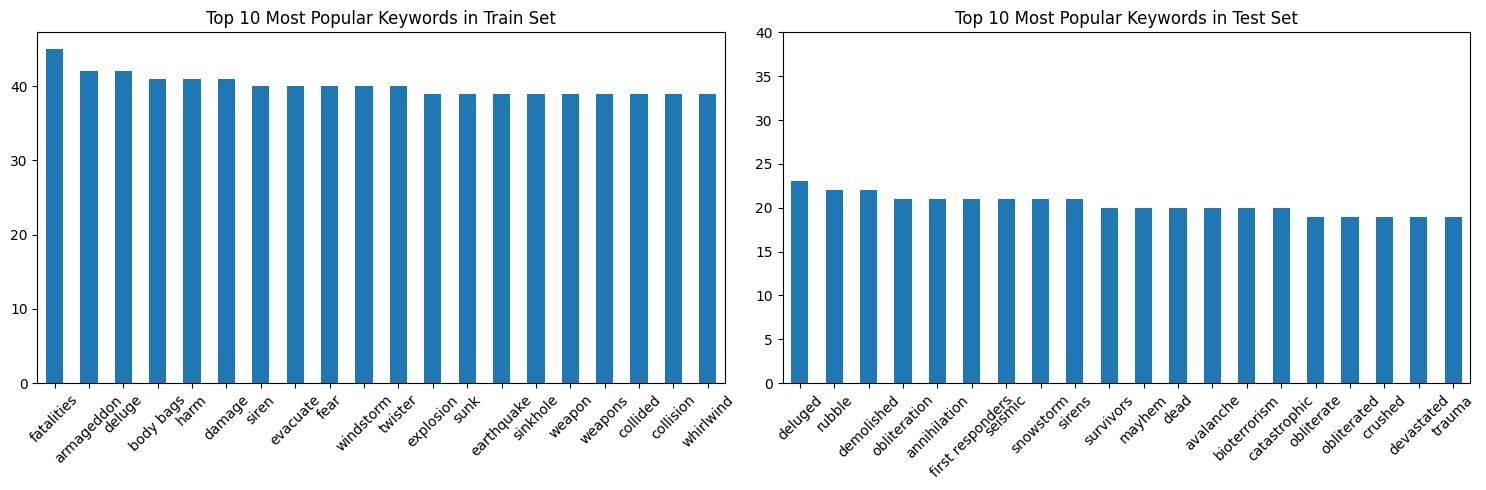

In [14]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

df_train['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[0]
    , rot=45
);
axes[0].set_title('Top 10 Most Popular Keywords in Train Set')
axes[0].set_xlabel(None)


df_test['keyword_clean'].value_counts().head(20).plot(
    kind='bar'
    , ax=axes[1]
    , rot=45
);
axes[1].set_title('Top 10 Most Popular Keywords in Test Set')
# Manually set y-axis limits for second plot for relative comparison
axes[1].set_ylim([0, 40])
axes[1].set_xlabel(None)

plt.tight_layout()

The only thing that stands out with the keywords is that they still have uniform resource identifier (URI) percent encoding for spaces as %20s. That is an easy find-and-replace.

We then check out the 10 most common keywords in the train and test sets, mostly looking to see if the same keywords show up in each. Interestingly, they do not overlap. I was expecting them to. This could be chance, or it could be that we have a curated test set where the common values purposely do not match. Either way, this will not change our approach to modeling later.

Next, we will figure out what to do with the location feature.

In [15]:
print(f"Train: number of unique locations: {df_train['location'].nunique(dropna=False):,}")
print(f"Test:  number of unique locations: {df_test['location'].nunique(dropna=False):,}")
print()

in_train_not_test, in_test_not_train = train_test_diffs(df_train['location'], df_test['location'])
print(f'Number of unique locations in train but not test: {len(in_train_not_test):,}')
print(f'Number of unique locations in test but not train: {len(in_test_not_train):,}')

# Just for kicks
df_train['location'].value_counts().sample(100, random_state=8675309)
# df_test['location'].value_counts().sample(100, random_state=8675309)

Train: number of unique locations: 3,328
Test:  number of unique locations: 1,603

Number of unique locations in train but not test: 2,906
Number of unique locations in test but not train: 1,181


location
Skyport de la Rosa                1
åø\_(?)_/åø                       1
Atlanta Georgia                   1
'SAN ANTONIOOOOO'                 1
Fort Walton Beach, Fl             1
                                 ..
Washington, USA                   2
Santiago,RepÌ¼blica Dominicana    1
RhodeIsland                       1
Hamilton County, IN               1
Near Warrington                   1
Name: count, Length: 100, dtype: int64

This feature is all over the place. There are about 3,000 locations in the train set that are not in the test set, and there are about 1,200 in reverse. The sample of 100 locations from the training set have some valid locations, some that need a bit of interpretation or judgment to parse out, and some that are useless. The main issue is that I do not see a way to programmatically clean these up, and, since there are thousands that we would need to go through by hand, manual clean up is not the most important use of time for this iteration. We will leave the location feature out of modeling for this iteration of the project, though this is an area to return to in future iterations to try and capture more info.

Next we check out the text feature.

In [16]:
tweet_num_chars_train = df_train['text_ascii'].str.len()
tweet_num_chars_test = df_test['text_ascii'].str.len()
tweet_num_words_train = df_train['text_ascii'].str.split().str.len()
tweet_num_words_test = df_test['text_ascii'].str.split().str.len()
print('Train character counts:')
print(tweet_num_chars_train.describe())
print()
print('Test character counts:')
print(tweet_num_chars_test.describe())
print()
print('Train word counts:')
print(tweet_num_words_train.describe())
print()
print('Test word counts:')
print(tweet_num_words_test.describe())

Train character counts:
count    7503.000000
mean      100.585632
std        33.648359
min         7.000000
25%        77.000000
50%       106.000000
75%       133.000000
max       157.000000
Name: text_ascii, dtype: float64

Test character counts:
count    3263.000000
mean      101.787312
std        33.748604
min         5.000000
25%        78.000000
50%       109.000000
75%       133.000000
max       151.000000
Name: text_ascii, dtype: float64

Train word counts:
count    7503.000000
mean       14.866187
std         5.734967
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_ascii, dtype: float64

Test word counts:
count    3263.000000
mean       14.949740
std         5.779087
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_ascii, dtype: float64


A quick statistical summary shows that the means, medians, and such between train and test are pretty close. One worry was if one of the datasets had noticeably different numbers of characters or words in the text feature, but we seem okay on that count.

Next, we will check out some distributions for the length of tweets.

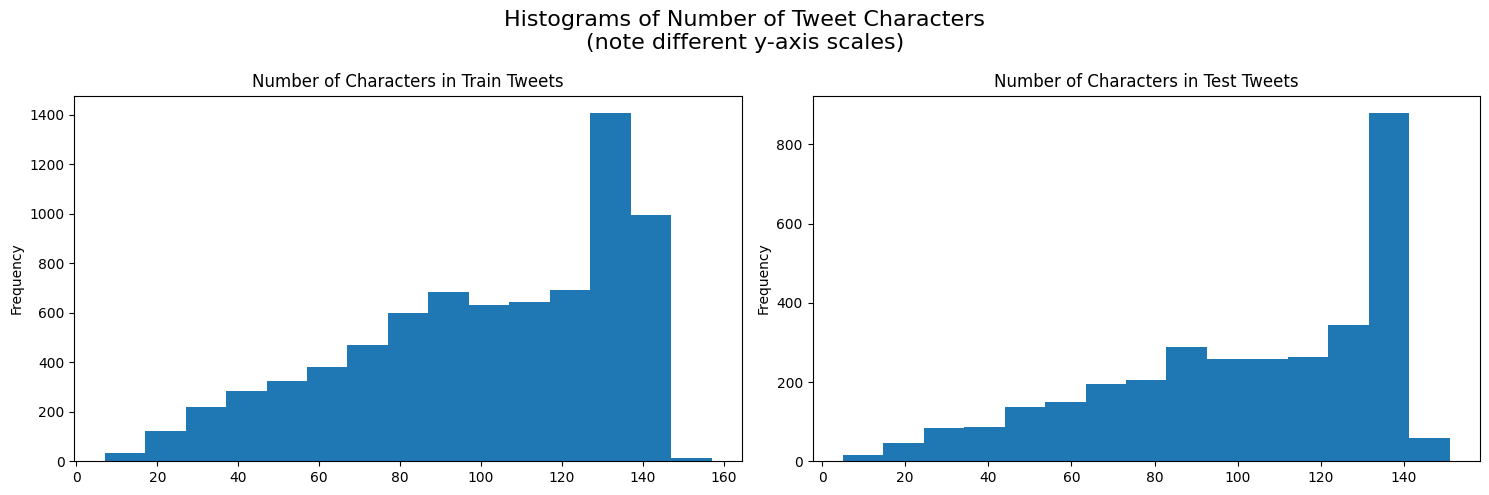

In [17]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

tweet_num_chars_train.plot(
    kind='hist'
    , ax=axes[0]
    , bins=15
);
axes[0].set_title('Number of Characters in Train Tweets')

tweet_num_chars_test.plot(
    kind='hist'
    , ax=axes[1]
    , bins=15
);
axes[1].set_title('Number of Characters in Test Tweets')
fig.suptitle('Histograms of Number of Tweet Characters\n(note different y-axis scales)', fontsize=16)
plt.tight_layout()

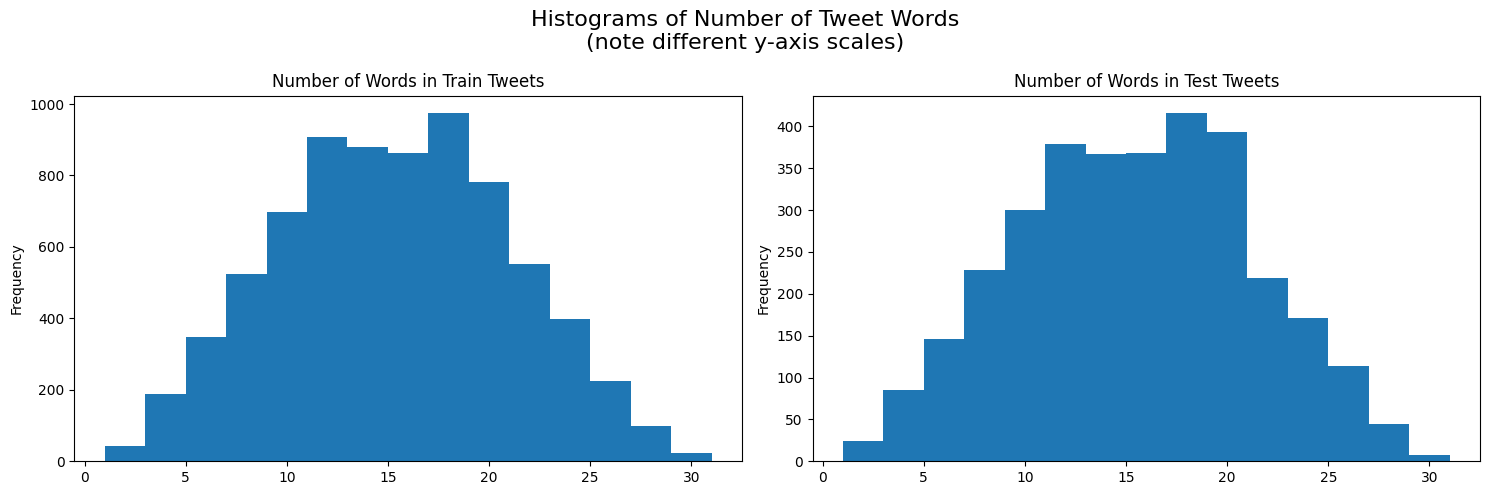

In [18]:
fig, axes = plt.subplots(
    nrows=1
    , ncols=2
    , figsize=(15, 5)
)

tweet_num_words_train.plot(
    kind='hist'
    , ax=axes[0]
    , bins=15
);
axes[0].set_title('Number of Words in Train Tweets')

tweet_num_words_test.plot(
    kind='hist'
    , ax=axes[1]
    , bins=15
);
axes[1].set_title('Number of Words in Test Tweets')

fig.suptitle('Histograms of Number of Tweet Words\n(note different y-axis scales)', fontsize=16)
plt.tight_layout()

The top pair of histograms shows character counts, and the bottom pair shows word counts. Similar to the stats just above, the distributions between train and test look similar, so we do not need to account for dissimilar distributions.

Similar to what we saw with locations, the quality of tweet text is pretty variable. Some are even hard to understand when manually skimming through them. It is not yet clear what, if any, extra preprocessing we may need to apply to the text feature. For instance, depending on the needs of modeling, we may want to clean up special characters, remove hyperlinks, try to identify quotes based on patterns of blocks of text between double quotes with what looks like one to three words after for names, etc. We also would need to try and identify outliers. There are so many variations though that this also may not be the best use of time in this iteration.
 
My preference is to do some modeling with the text feature as is. We can always return to cleaning this feature up if we run into problems with modeling or in future iterations as extra testing on how to continue improving modeling performance. But, for now, we will leave the remaining cleanup of the text feature for a later time.

Finally, we will take a look at the target feature, primarily looking for class balance.

Percentage of 0 labels: 0.574
Percentage of 1 labels: 0.426



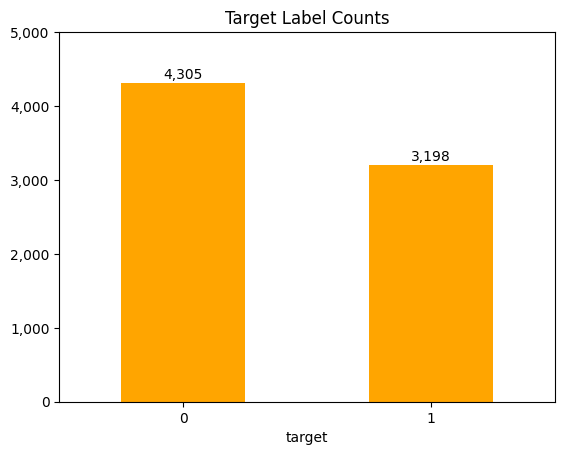

In [19]:
label_counts = df_train.groupby('target').count().iloc[:,0]
zeros = label_counts[0]
ones = label_counts[1]

print(f'Percentage of 0 labels: {zeros/(zeros+ones):.3f}')
print(f'Percentage of 1 labels: {ones/(zeros+ones):.3f}')
print()

ax = label_counts.plot(
    kind='bar'
    , rot=0
    , legend=False
    , color='orange'
    , title='Target Label Counts'
);

ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=1
);

# matplotlib throws a warning if you do not set the axis label values before then 
# reformatting the labels, so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

It looks like we have a 60-40 split between 0s (not a real disaster) and 1s (is a real disaster). I feel fine with this split, though it is an area we could circle back to in future modeling iterations to adjust to a 50-50 split to see if that affects model performance.

With that, I think we have the dataset ready to start exploring modeling. We noted a few areas where we may want to return during this iteration of the project or in future iterations. Note that removing non-ASCII characters handled some of the other cleanup we would need to do, but it skipped cleaning up some punctuation or groups of characters such as URLs, but we will save those for a future iteration after we have the modeling pipeline up and running.

For now, we will let modeling guide us on if we need to return to anything above, and, in order to do that, we need to pivot to the modeling itself.

With one more stop along the way.

## Word Embeddings

The final preprocessing we need is to set the data up for word embeddings. Machine learning models cannot work with raw text, so we need to convert text to numbers in matrix form. From there, we can add an extra embedding step that provides more information about the words.

I like the approach of building up to more complicated word embeddings. To start out, we need a strategy for the first step of turning text into numbers. We could one-hot encode all the words in all the tweets. To put some terminology in here, we use 'vocabulary' to define the set of all words that show up in across all of the 'documents' (in this case, one tweet is one document). So one-hot encoding gives us, for each document, a matrix with one row per word in that document and the entire vocabulary as the feature space. For this project, each of these matrices would be sparse since we have a vocabulary of around 20,000 words, but the maximum number of words per tweet is 31. Outside of those 31 1s in the one-hot encoded matrix, everything else is 0s, and we repeat this across all tweets.

So we need an improved strategy. There are two issues I see already. First is the sparsity of each matrix. Second is that we have more than one matrix. We will tackle the latter by switching from one matrix per tweet to one row per tweet in a shared matrix with all the tweets combined. We will keep the vocabulary as the feature space. Now, instead of one-hot encoding, we can put a 1 anywhere in a row that indicates that the word for that feature is present in that tweet. While this does not solve the sparsity problem, it does simplify from having one matrix per tweet to having one shared matrix with multiple 1s per row.

For this project, we will go with an alternate version of the last step. Instead of setting up a matrix, we will create a list of the vocabulary, and then we will replace each word in each tweet with the index of that word in the vocabulary list. This both reduces the numeric encoding issue down and reduces the sparse matrix issue.

Note that at this stage we have all of our text documents encoded as numeric vectors, so the machine learning algorithms are able to work with the data in numeric vector representation. (This is the TextVectorization() code block below). The next issue is that we are only indicating word presence. We would like to supply a bit more context to each word. Enter word embeddings. There are a couple of common embedding strategies such as TFIDF and Word2Vec. I should note too that there are also other steps such as Bag of Word encodings that supply counts of words in a tweet instead of boolean flags for presence. I will put a short summary of these different approaches below after describing what we will use for this project.

Word embeddings are representations of words. The representation we are looking for is one vector per word so that we can use vector operations such as dot products to determine how similar or dissimilar two words are. We will now replace the lookup list of vocabulary with a vocabulary matrix where we have one row per word in the vocabulary and will set a hyperparameter value for the number of features. In theory, more features provide more dimensions on which to capture aspects of words, though too many features run the risk of overfitting on the specific tweets in the training set. The vocabulary matrix is a set of weights that we will tune during model training. (This is the layers.Embedding() layer in the models. Note that these are calculated during model training and not beforehand like the TextVectorization() call that happens on its own before we share its output to the models.)

After model training, the weights in this vocabulary matrix will be tuned to capture similarity between different words, providing us extra information for the model to use when trying to glean meaning for classification purposes. For example, the model may pick up on "fire", "blaze", "hot", "scorch", and other words related to fire as being similar, so, if it picks up on a pattern in tweets with "fire" that indicate that we are looking at a real disaster tweet, it may be able to use word similarity from the vocabulary matrix to share that pattern with other words deemed similar to "fire."

So, at this stage, we have converted tweets into the index of each word in a vocabulary lookup list, and then we pass that along to the model to tune a vocabulary matrix as part of model training. We have converting text to numbers and provided the model the ability to glean extra insight from the words to use for its primary classification focus.

### Other Approaches

- Bag of Words
    
    One approach we could use in place of the index lookup is to create a Bag of Words (BoW) encoding. This would create a matrix with one row per tweet and one feature per word in the vocabulary. The difference from above is that each cell would hold a count of how many times that word shows up in a given tweet. This is another way to provide extra context about the text beyond word presence.
    
- Text Frequency Inverse Document Frequency (TFIDF)

    Another approach to the initial encoding steps is TFIDF. The TF portion starts with a BoW encoding and divides each row by the total number of words in that tweet. This gives us a proportional representation of what percent of the total words in the tweet that each word accounts for. Similar to the BoW model, this provides extra context beyond simple boolean presence flags. But TFIDF does have some issues. We expect words that are more common in the English language (for English tweets) to show up more often, so they would have higher TFs, but those higher TFs may not help us for classification.
    
    For example, the word "the" will show up more more often than most, if not all, other words, but "the" does not help us to classify if a tweet is about a real disaster, so we need a way to adjust for this. In steps the IDF portion of TFIDF. We now look at each word in the vocabulary and track how many documents it shows up in. We then take the log of the inverse of that amount. So, for "the", we get log[1/(# of docs "the" shows up in)] to get the IDF. If "the" shows up in a lot of tweets, then it ends up with a lower IDF. 
    
    We then multiply the TF by the IDF, so there is a balance between wanting words that show up more often in a given tweet but are not common across all tweets. The hope is that a high TFIDF indicates words that are stronger signals in a given tweet in terms of meaning that can be used for classification while common words across all tweets or uncommon words in a given tweet that show up maybe once or twice in the whole vocabulary do not suck up as much attention from the model.

- Word2Vec

    Word2Vec is an embedding process as opposed to just an encoding step. This approach uses a deep learning model to learn the context around words and provide a feature vector for each word that captures that context. One cool aspect of Word2Vec is that you can do things like (I know it's the common example) King - Man + Woman = Queen. I like using Word2Vec, but it adds a whole new layer of complexity to the embedding step, and I would rather keep everything as simple as possible outside of the RNN modeling to stay focused on that for this project, though Word2Vec is probably my favorite embedding algorithm to use generally.

## Modeling

We will explore RNNs for modeling in this project. The key feature of RNNs is recurrence. The other artificial neural networks (ANNs), including convolutional neural networks (CNNs), that we have worked with so far are feed-forward neural networks, meaning each layer passes updates on to forward layers, but information does not move backwards. RNNs change this. We can think of a recurrent layer similar to a hidden layer in other ANNs except that the recurrent layer passes information back into itself in a loop for each element of the input. 

Here is an oversimplified conceptual example and ignoring the math of what gets combined where. If we have a tweet with five words, we can think of a simplified RNN as one recurrent layer and one output layer. The first input goes into the recurrent layer, and then the recurrent layers passes weights back to itself to combine with the information coming in from the second input. We repreat this cycle until the fifth input gets processed by the recurrent layer. We then pass the output of the fifth cycle forward to the classification output layer.

While it is accurate that we have one hidden recurrent layer in this example, we can think about this conceptually as one recurrent hidden layer being unfolded into five separate hidden recurrent layers that share weight parameters between them. The sharing of weights is different from previous ANNs where each hidden layer would have its own weights. Here, the RNN is able to capture some information from previous recurrent layers to pass into the current recurrent layer, allowing the model to remember information or context that came before the current layer.

One important aspect of RNNs is that they work with sequences, sequences being inputs where order matters. In this project, the order of words is important since the text in tweets have an ordering to them. This ordering is important. RNNs, while they are not unidirectional, are directional in the sense that they process, for this project, the first word of a tweet, then the second word of a tweet, then the third, etc. A standard multi-layer perceptron (MLP) would process all of the words as input at the same time, and it would not have the ability to capture information about the processing of the first word to pass to the processing of future words.

Because of the RNNs ability to roll out more hidden recurrent layers to match the number of inputs, RNNs can receive inputs of varying length. This is relevant for our tweet classification since not all tweets have the same length.

It seems obvious now, but it was unclear to me at first that the way we implement RNNs in Keras is to add a recurrent layer once, and then the software understands to continue recurrence until all of the inputs make it through the model. We pass a parameter to the layer for the number of units in each hidden recurrent layer, similar to how we may have hidden layers in MLPs that have numbers of units in each that we specify as hyperparameters. We do not need to add multiple layers to try and accommodate the varying length inputs manually. If we choose to add more than one recurrent layer in Keras, that actually adds two separate sets of recurrent hidden layers in the model, and all inputs will go through both as part of one pass for that input through the model. This would be adding stacked recurrent layers. We will likely avoid adding stacked layers in Keras again due to worrying about ballooning scope and having too many changing hyperparameters.

RNNs do however have some known issues related to vanishing and exploding gradients during backpropagation. Since we are passing shared weights from unrolled recurrent layer to recurrent layer, we risk multiplying very small or very large gradients such that they get increasingly smaller or larger respectively, leading to vanishing or exploding gradients. If we run into either of these issues, we can look at approaches like gradient clipping where we manually cap gradients past a certain point. We can also look at using long short-term memory (LSTM) or gated recurrent unit (GRU) models, our next focus.

On top of addressing gradient issues, LSTMs and GRUs help with RNNs forgetting information from elements in a sequence that are far away from the current element. For example, by the time we get to the 25th word in a tweet, the RNN may have lost all of the information it was trying to pass from recurrent layer to recurrent layer due to how long ago it saw the first word. This information gets passed along through the shared weight matrix from hidden layer to hidden layer combined with outputs from hidden layers. In order to address these, we can employ extra methods for keeping or forgetting information from layer to layer. LSTMs and GRUs do this by determining in each layer how much of different pieces of information to retain or drop from previous layers. This allows the model to keep track of information from further back while dropping less impactful information that it saw more recently.

This project explores many-to-one RNN architectures for binary classification. This means we can accept numerous inputs (words in a tweet) that get compiled down to one output (yes or no for real disaster tweet). As mentioned earlier, to keep the complexity down on the first iteration of the project, we will only use the `text` feature as input, though we want to incorporate `keyword` and `location` in future iterations.

One worry I have is how to explore hyperparameter tuning in a way that is systematic but also covers enough scope to help refine the model in meaningful ways. There are a lot of hyperparameters we can tinker with in RNNs. Also, I know that there are early stopping methods in Keras, but my preference is to do the hyperparameter tuning manually as I am learning about RNNs and doing extra manual exploration of how they work, so all of the modeling and tuning below will be manual.

We will test out traditional RNNs, LSTMs, and GRUs. We will set a larger number of epochs to start with, and then we will reduce that over time as we get a sense of about how many epoch we can use before we see overfitting. We may explore batching for the inputs in the `fit()` method if we find performance is struggling.

One interesting design we can test out is adding in a bidirectional layer. RNNs pay attention to what has come before when processing the current input. Bidirectionality allows the RNN to pay attention to what comes after. The model does this by creating a second hidden recurrent layer that process inputs in reverse order. It makes sense that our model may want to adjust the importance of words in a tweet based on what has come before and what is coming ahead, so we can explore adding this to modeling.

We can also look at adding in dropout, L1, or L2 regularization, but we will only reach for these if we run into overfitting issues.

We will stick with the adaptive moment estimation (adam) optimizer. We may look at changing its learning rate, but I would rather not start exploring optimizers since that moves us away from comparing different RNN-specific hyperparameters.

And finally, if we go through the above and find that the models are still struggling in terms of classification performance, then we can return back to the word embeddings process and introduce n-grams. These are n words, in this scenario, considered as groups. So, if processing one word at a time is not working, we can instead have the model process words in pairs instead, with the remaining ideas above about word embeddings remaining the same.

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train['text_ascii']
    , df_train['target']
    , test_size=0.2
    , random_state=8675309
)

x_test = df_test['text_ascii']

In [21]:
# Utility function that takes in an np.array() of prediction probabilities
# and saves them to a CSV with 0 and 1 labels for competition submission
def gimme_preds(predictions, name):    
    pd.DataFrame({
        'id': df_test['id']
        , 'target': np.where(predictions >= 0.5, 1, 0).reshape(-1,)
#         , 'raw_target': predictions.reshape(-1,) # Used to check that the previous line is working right
    }).to_csv(f'{out_dir}/preds_{name}.csv', index=False)

In [22]:
def gimme_plots(history):
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(20,10)
    )

    # Note that epochs are offset by one due to zero indexing    
    axes[0].plot(history.history['loss'], label='loss');
    axes[0].plot(history.history['val_loss'], label='val_loss');
    axes[0].set_xlabel('epoch');
    axes[0].set_ylabel('loss');
    axes[0].legend(loc='lower right');
    axes[0].set_title('Loss vs Epoch');

    axes[1].plot(history.history['f1_score'], label='f1_score');
    axes[1].plot(history.history['val_f1_score'], label='val_f1_score');
    axes[1].set_xlabel('epoch');
    axes[1].set_ylabel('F1 Score');
    axes[1].set_ylim([0, 1]);
    axes[1].legend(loc='lower right');
    axes[1].set_title('F1 Score vs Epoch');

In [23]:
loss = 'binary_crossentropy'
metric = 'f1_score'

def gimme_models(name, model, epochs=20, learning_rate=0.001):
    model.summary()

    model.compile(
        optimizer=optimizers.Adam(learning_rate)
        , loss=loss
        , metrics=[metric]
    )

    hist = model.fit(
        x=x_train
        , y=y_train
        , epochs=epochs
        , validation_data=(x_val, y_val)
    )

    gimme_plots(hist)

    preds = model.predict(
        x_test
        , verbose=2
    )

    gimme_preds(preds, name)

In [24]:
index_vectorizer = layers.TextVectorization(
    standardize='lower_and_strip_punctuation'
    , split='whitespace'
    , output_mode='int'
    # Make sure we pad so that all tweets are the same length as the longest tweet
    , output_sequence_length=max(tweet_num_words_train)
)
index_vectorizer.adapt(x_train)

In [25]:
# dropout separate layers
#
# dropout within recurrent layers -- layers.XXX(dropout=0.2, recurrent_dropout=0.2) 
# (dropout is for inputs to the recurrent layer and recurrent_dropout is for connections between recurrent connections)
#
# regularization -- layers.XXX(kernel_regularizer=tf.keras.regularizers.l2(0.01))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - f1_score: 0.6027 - loss: 0.6113 - val_f1_score: 0.6031 - val_loss: 0.4719
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - f1_score: 0.5960 - loss: 0.2203 - val_f1_score: 0.6031 - val_loss: 0.5638
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - f1_score: 0.5900 - loss: 0.0523 - val_f1_score: 0.6031 - val_loss: 0.6939
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - f1_score: 0.5945 - loss: 0.0210 - val_f1_score: 0.6031 - val_loss: 0.7957
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - f1_score: 0.6072 - loss: 0.0080 - val_f1_score: 0.6031 - val_loss: 0.8102
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - f1_score: 0.5912 - loss: 0.0054 - val_f1_score: 0.6031 - val_loss: 0.9204
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - f1_score: 0.5921 - loss: 0.0035 - val_f1_score: 0.6031 - val_loss: 0.9747
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - f1_score: 0.5994 - loss: 0.0034 - val

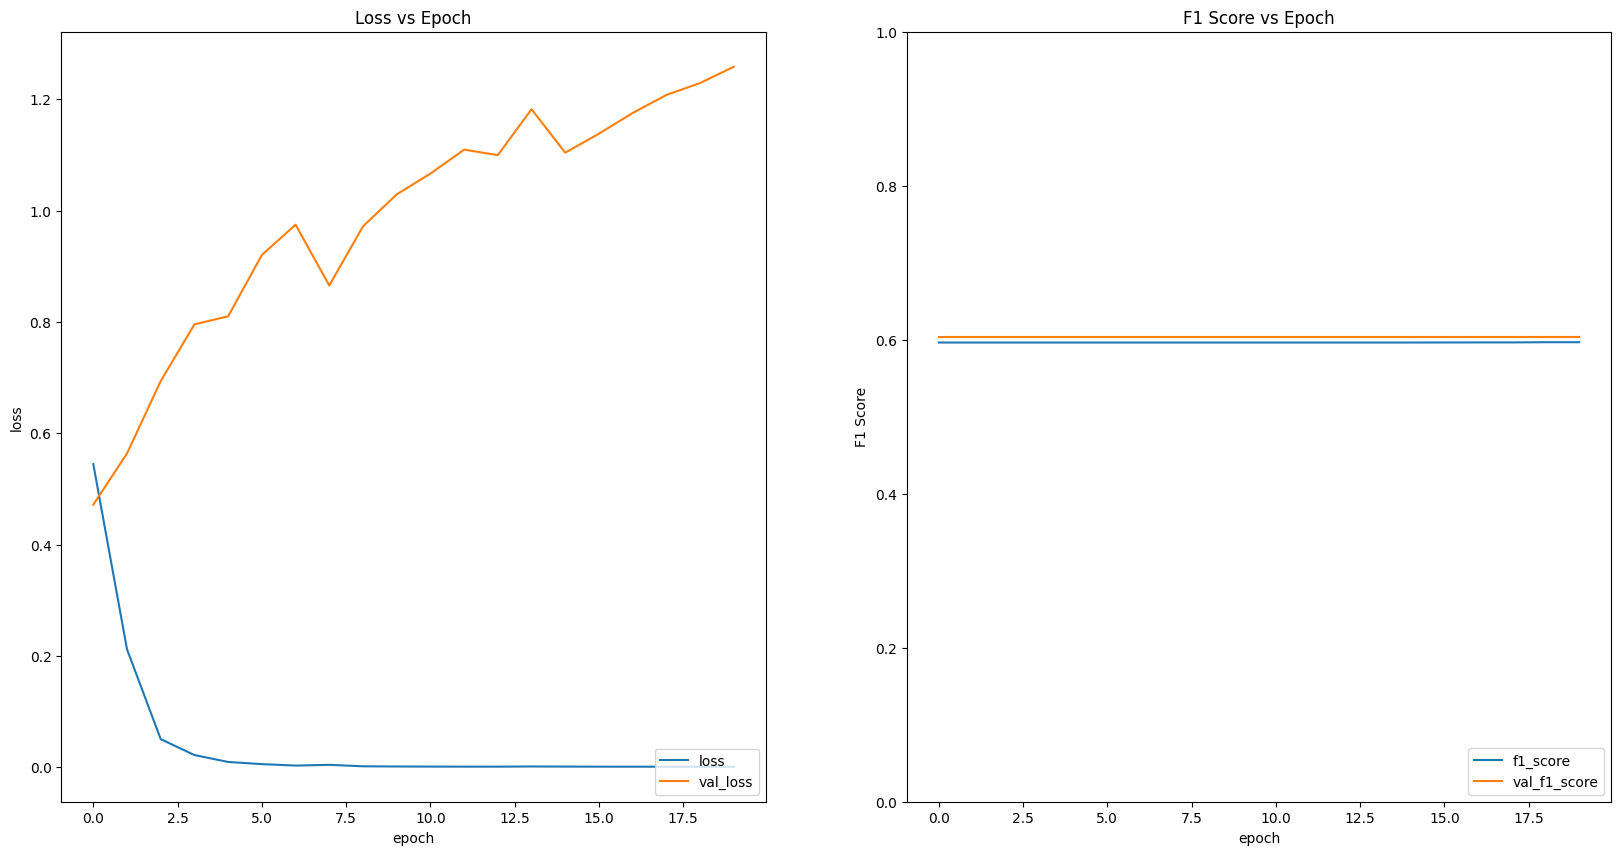

In [26]:
gimme_models(
    'simplernn_01'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size() # Matches the size of the vocabulary
            , output_dim=100 # Number of embedding features per word
            , mask_zero=True # Flags that we padded tweets in TextVectorization() with 0s
        )
        , layers.SimpleRNN(64, activation='tanh')
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 31)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - f1_score: 0.6014 - loss: 0.6184 - val_f1_score: 0.6031 - val_loss: 0.4626
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - f1_score: 0.6101 - loss: 0.1898 - val_f1_score: 0.6031 - val_loss: 0.5790
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - f1_score: 0.5945 - loss: 0.0470 - val_f1_score: 0.6031 - val_loss: 0.7318
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - f1_score: 0.6005 - loss: 0.0304 - val_f1_score: 0.6031 - val_loss: 0.8402
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - f1_score: 0.6072 - loss: 0.0096 - val_f1_score: 0.6031 - val_loss: 1.0998
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - f1_score: 0.5946 - loss: 0.0127 - val_f1_score: 0.6031 - val_loss: 0.9336
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - f1_score: 0.5944 - loss: 0.0080 - val_f1_score: 0.6031 - val_loss: 0.9820
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - f1_score: 0.5885 - loss: 0.0019 - 

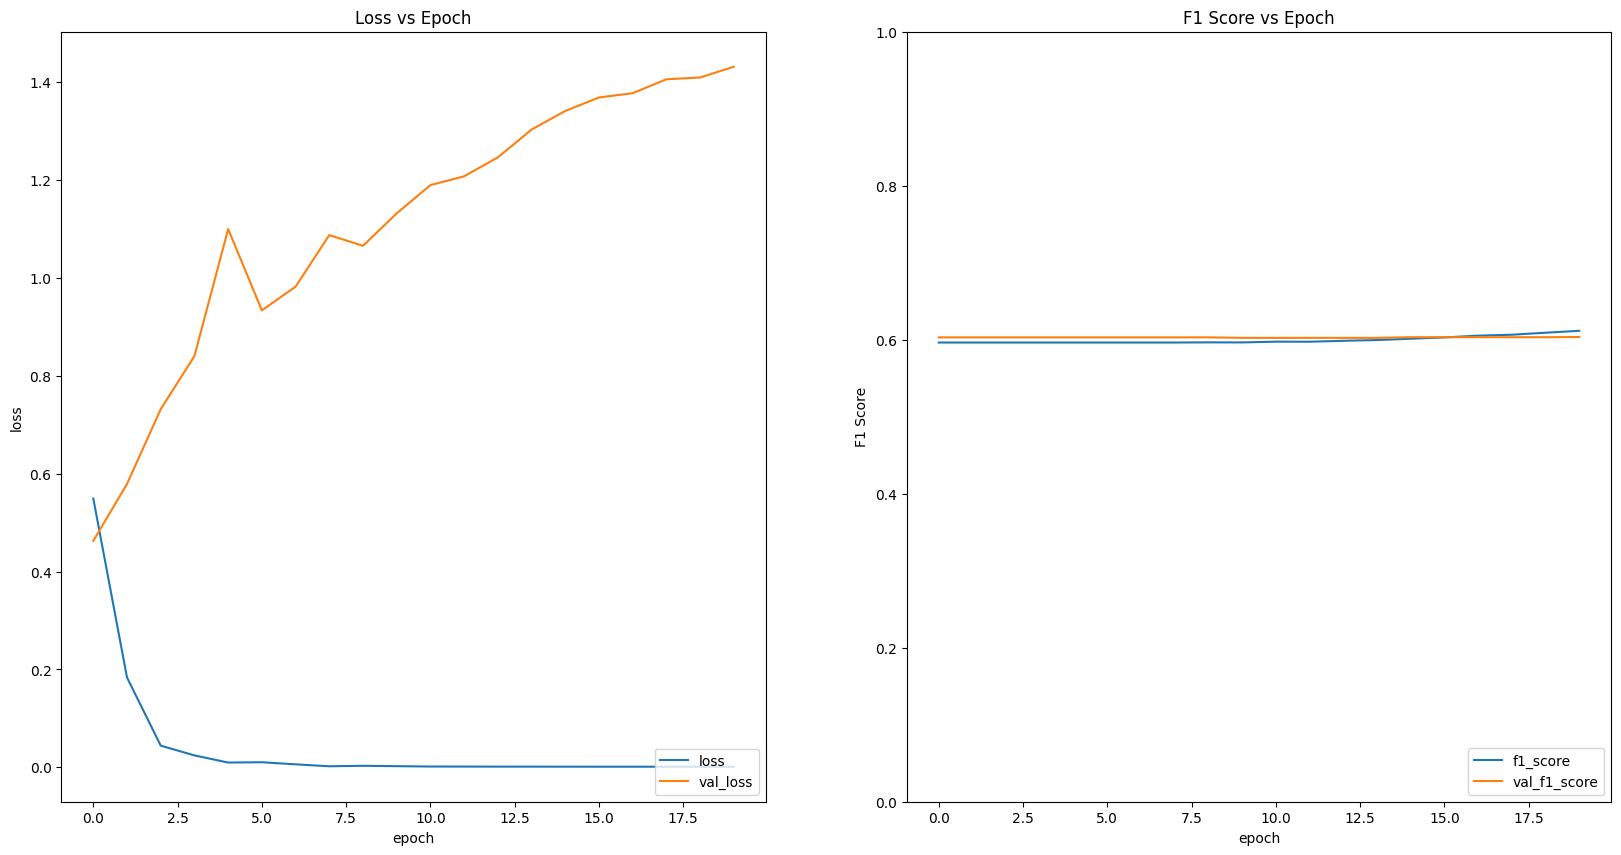

In [27]:
gimme_models(
    'simplernn_02'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size() # Matches the size of the vocabulary
            , output_dim=100 # Number of embedding features per word
            , mask_zero=True # Flags that we padded tweets in TextVectorization() with 0s
        )
        , layers.Bidirectional(layers.SimpleRNN(64, activation='tanh'))
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 31)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - f1_score: 0.5948 - loss: 0.6017 - val_f1_score: 0.6031 - val_loss: 0.4435
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - f1_score: 0.6025 - loss: 0.2509 - val_f1_score: 0.6031 - val_loss: 0.5904
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6052 - loss: 0.0776 - val_f1_score: 0.6031 - val_loss: 0.7266
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6061 - loss: 0.0306 - val_f1_score: 0.6031 - val_loss: 0.9133
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6021 - loss: 0.0223 - val_f1_score: 0.6031 - val_loss: 0.7963
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6055 - loss: 0.0121 - val_f1_score: 0.6031 - val_loss: 1.0174
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5965 - loss: 0.0068 - val_f1_score: 0.6031 - val_loss: 1.0794
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6065 - loss: 0.0039 - val_f1_score: 0

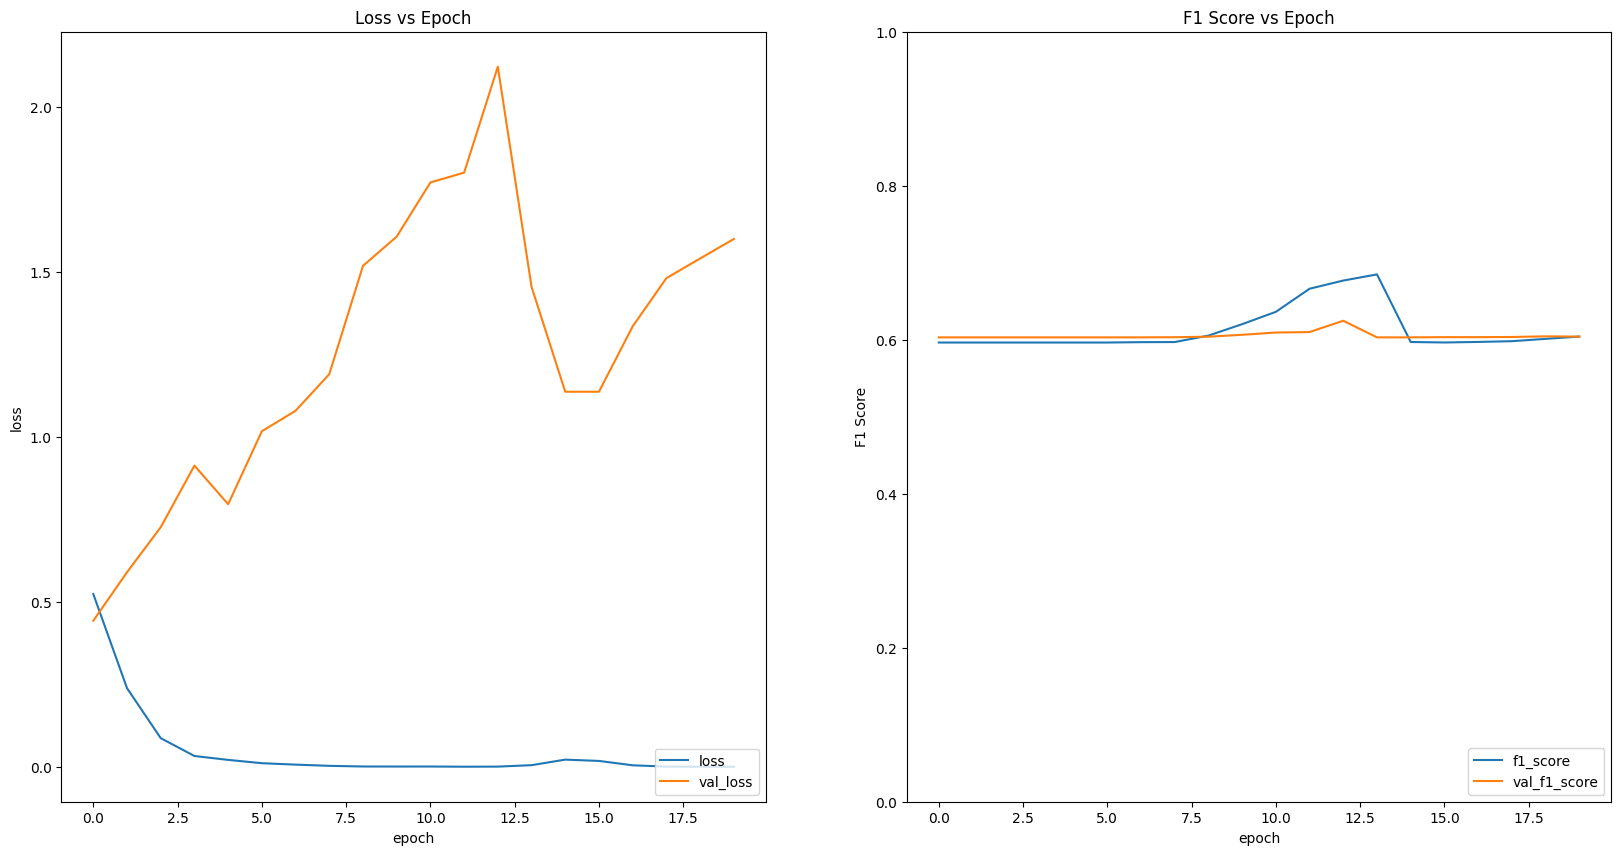

In [28]:
gimme_models(
    'lstm_01'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size()
            , output_dim=100
            , mask_zero=True
        )
        , layers.LSTM(64, activation='tanh')
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 31)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - f1_score: 0.5898 - loss: 0.5991 - val_f1_score: 0.6031 - val_loss: 0.4308
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - f1_score: 0.6154 - loss: 0.2263 - val_f1_score: 0.6031 - val_loss: 0.5010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.6106 - loss: 0.0699 - val_f1_score: 0.6031 - val_loss: 0.6220
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5978 - loss: 0.0277 - val_f1_score: 0.6031 - val_loss: 0.8338
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5965 - loss: 0.0141 - val_f1_score: 0.6031 - val_loss: 0.9451
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5972 - loss: 0.0071 - val_f1_score: 0.6052 - val_loss: 1.2724
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.6001 - loss: 0.0058 - val_f1_score: 0.6031 - val_loss: 0.9988
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5983 - loss: 0.0046 - val_f1_score: 

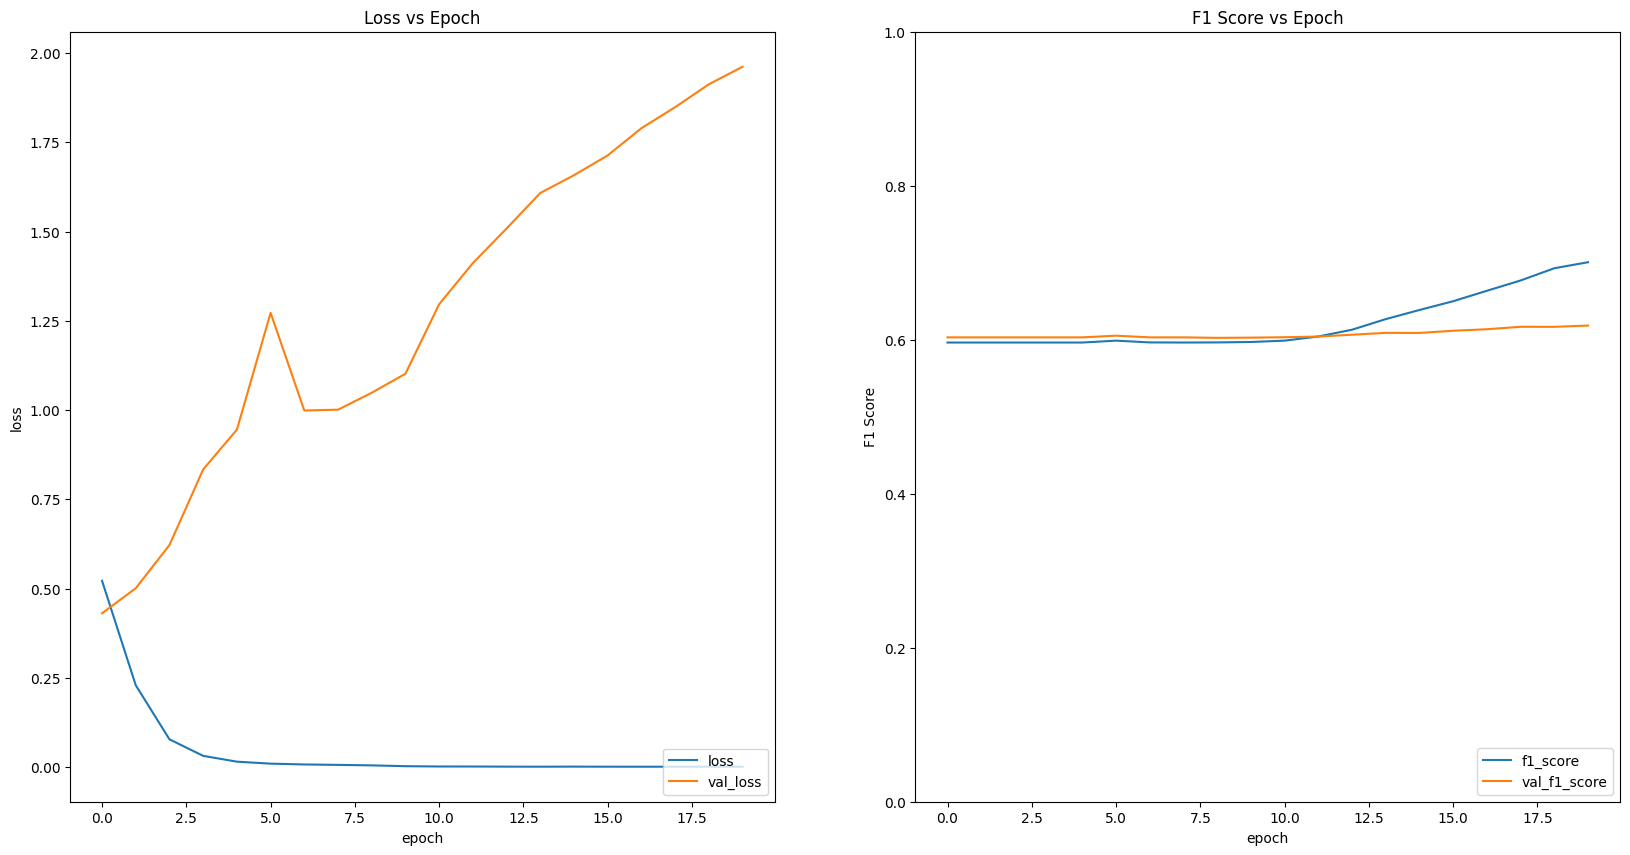

In [29]:
gimme_models(
    'lstm_02'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size()
            , output_dim=100
            , mask_zero=True
        )
        , layers.Bidirectional(layers.LSTM(64, activation='tanh'))
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 31)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - f1_score: 0.5887 - loss: 0.6289 - val_f1_score: 0.6031 - val_loss: 0.4527
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5907 - loss: 0.2599 - val_f1_score: 0.6031 - val_loss: 0.5137
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5865 - loss: 0.0693 - val_f1_score: 0.6031 - val_loss: 0.6381
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6032 - loss: 0.0291 - val_f1_score: 0.6031 - val_loss: 0.8585
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5951 - loss: 0.0179 - val_f1_score: 0.6031 - val_loss: 1.0196
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.6056 - loss: 0.0135 - val_f1_score: 0.6031 - val_loss: 0.9479
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5956 - loss: 0.0072 - val_f1_score: 0.6031 - val_loss: 1.0294
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - f1_score: 0.5935 - loss: 0.0066 - val_f1_score: 0.

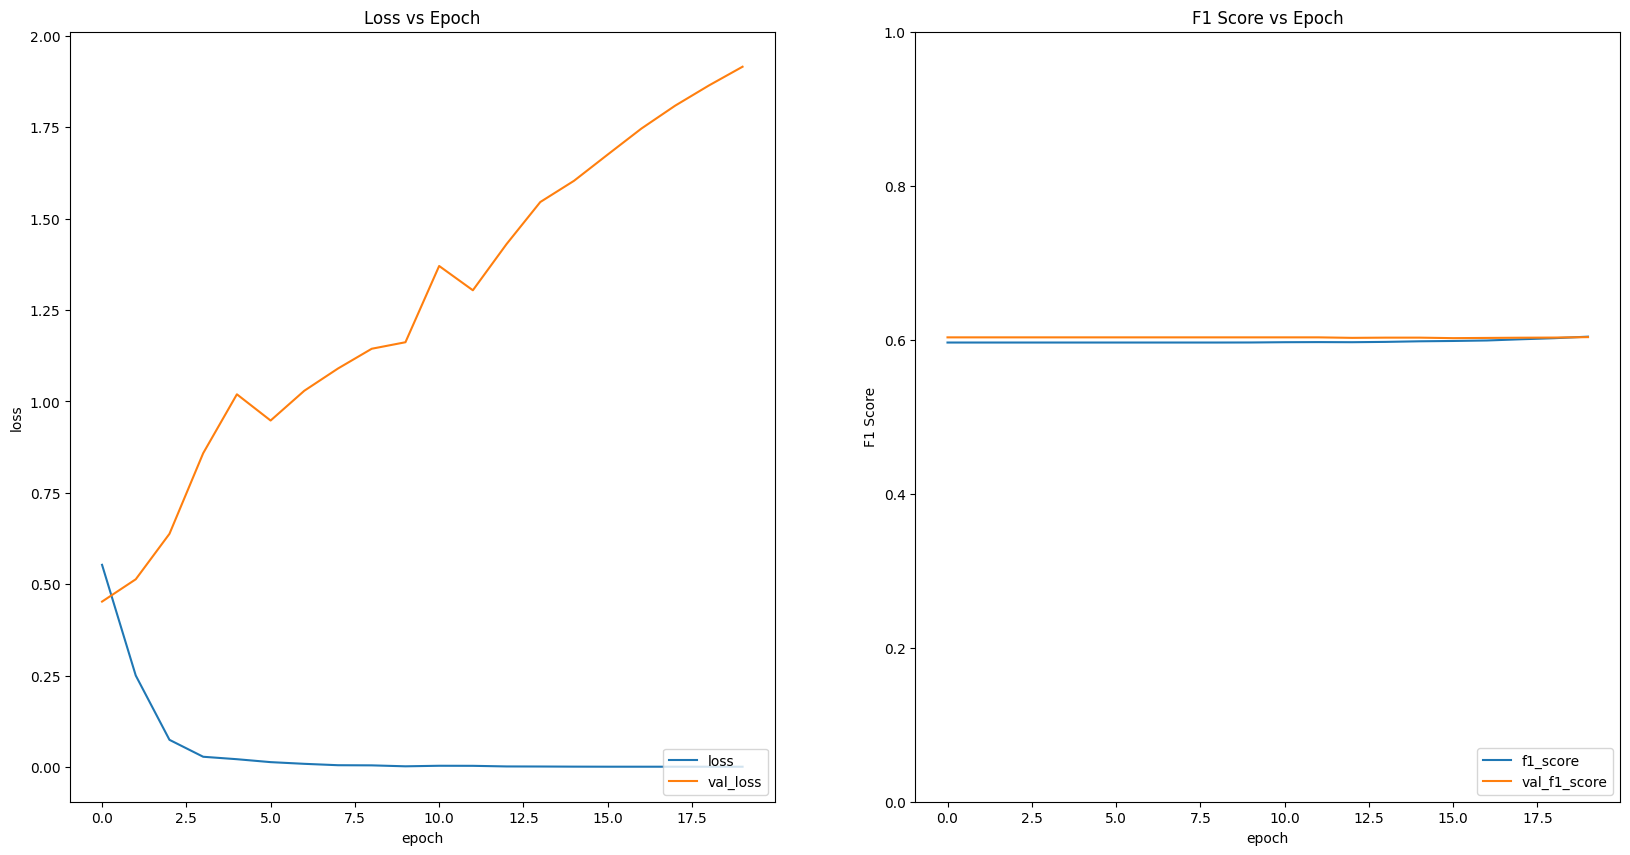

In [30]:
gimme_models(
    'gru_01'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size()
            , output_dim=100
            , mask_zero=True
        )
        , layers.GRU(64, activation='tanh')
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 31)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - f1_score: 0.6071 - loss: 0.6169 - val_f1_score: 0.6031 - val_loss: 0.4337
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.6021 - loss: 0.2282 - val_f1_score: 0.6031 - val_loss: 0.5026
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5947 - loss: 0.0585 - val_f1_score: 0.6031 - val_loss: 0.6945
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5939 - loss: 0.0211 - val_f1_score: 0.6031 - val_loss: 0.8135
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5912 - loss: 0.0142 - val_f1_score: 0.6031 - val_loss: 0.9226
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5800 - loss: 0.0073 - val_f1_score: 0.6031 - val_loss: 0.9824
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5899 - loss: 0.0041 - val_f1_score: 0.6031 - val_loss: 1.1467
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - f1_score: 0.5983 - loss: 0.0013 - val_f1_score: 0

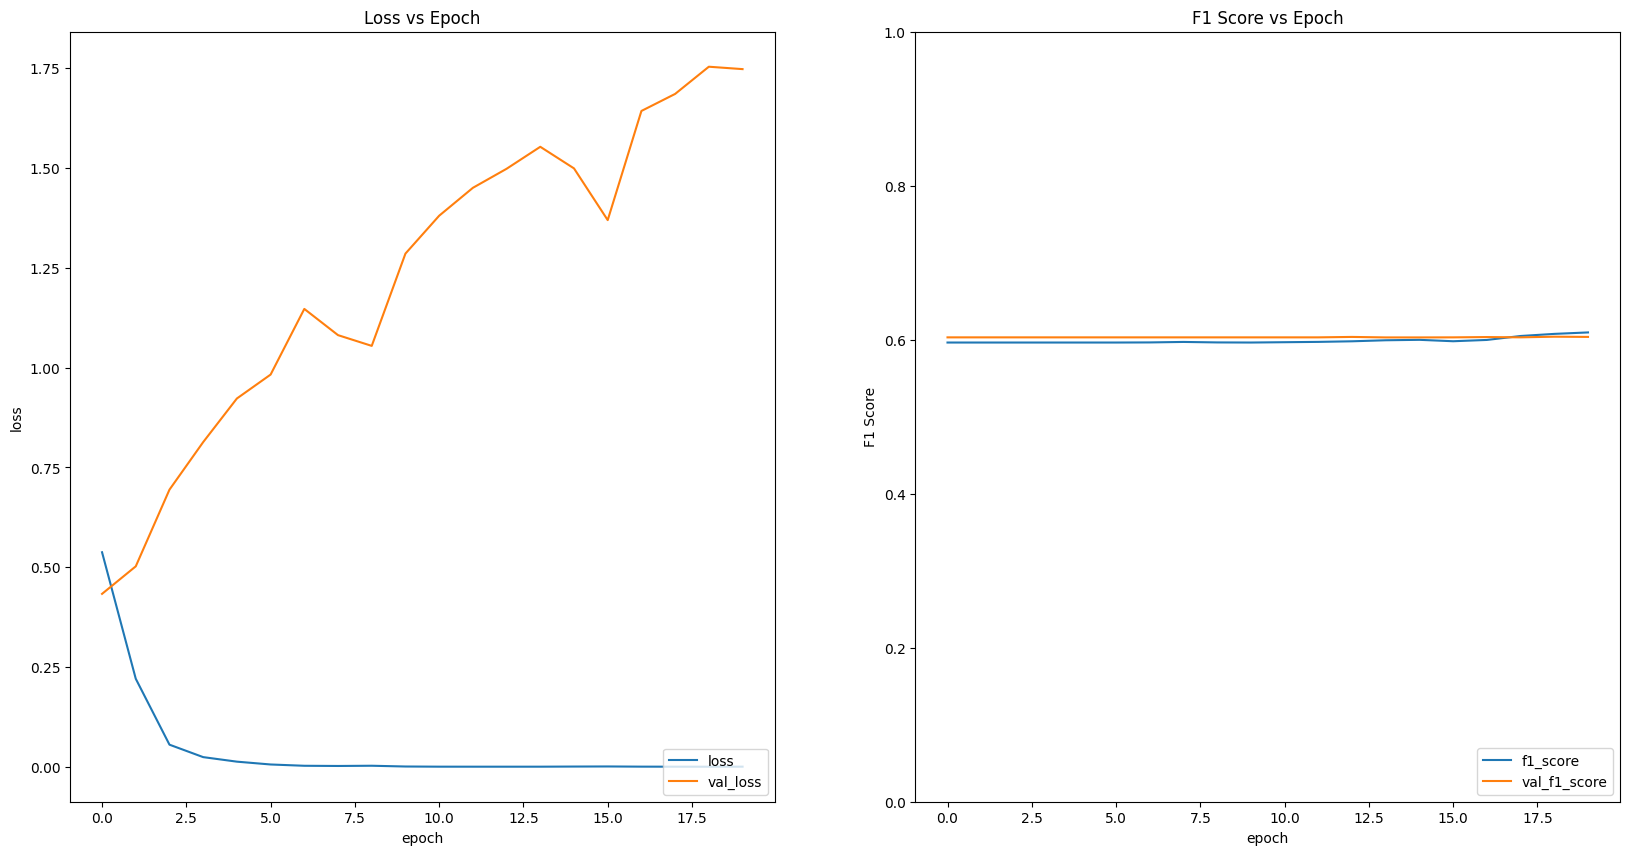

In [31]:
gimme_models(
    'gru_02'
    , models.Sequential([
        index_vectorizer
        , layers.Embedding(
            input_dim=index_vectorizer.vocabulary_size()
            , output_dim=100
            , mask_zero=True
        )
        , layers.Bidirectional(layers.GRU(64, activation='tanh'))
        , layers.Dense(64, activation='relu')
        , layers.Dense(1, activation='sigmoid')
    ])
)

## Modeling Results and Summary

## Conclusion

## References

RNNs:
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

Good ol' Wikipedia starting points for NLP topics:
- https://en.wikipedia.org/wiki/Document_classification 
- https://en.wikipedia.org/wiki/Feature_(machine_learning)#Feature_vectors
- https://en.wikipedia.org/wiki/Word_embedding
- https://en.wikipedia.org/wiki/Bag-of-words_model
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/Word2vec
- https://en.wikipedia.org/wiki/Stop_word
- https://en.wikipedia.org/wiki/Self-supervised_learning

Global Vectors for Word Representation (GloVe): 
- https://nlp.stanford.edu/projects/glove/
- https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

Readings on turning text into vectors:
- https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

Tensorflow docs:
- https://www.tensorflow.org/text/tutorials/word2vec
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/text/guide/word_embeddings
- https://www.tensorflow.org/guide/keras/working_with_rnns

Word2Vec and word embeddings:
- https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

Hyperparameter tuning strategies:
- https://medium.com/@rustemgal/practical-hyper-parameter-tuning-for-any-deep-neural-net-303cc537fd01
- https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594
- https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8

Videos:
- https://www.youtube.com/watch?v=TI4HRR3Hd9A
- https://www.youtube.com/watch?v=0XdPIqi0qpg
- https://www.youtube.com/watch?v=GQb21TGWucs
- https://www.youtube.com/watch?v=FBlPZJrJt9g
- https://www.youtube.com/watch?v=rdz0UqQz5Sw
- https://www.youtube.com/watch?v=DFZ1UA7-fxY
- https://www.youtube.com/watch?v=Y2wfIKQyd1I
- https://www.youtube.com/watch?v=LfnrRPFhkuY